In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si
import scipy.special as ss
import scipy.stats as st
from scipy.fftpack import fft, ifft
import utils as u
import fake_profile as fp
import csv

In [2]:
a1 = [3,5]
mu1 = [30,40]
sd1 = [1,1]

a2 = [3,5]
mu2 = [55,65]
sd2 = [1,1]

a3 = [3,5]
mu3 = [70,80]
sd3 = [1,1]

In [5]:
p1 = fp.fake_profile(a1,mu1,sd1); p1.construct_profile(noise=True)
p2 = fp.fake_profile(a2,mu2,sd2); p2.construct_profile(noise=True)
p3 = fp.fake_profile(a3,mu3,sd3); p3.construct_profile(noise=True)

data = np.vstack((p1.profile,p2.profile,p3.profile))
nprof = len(data)

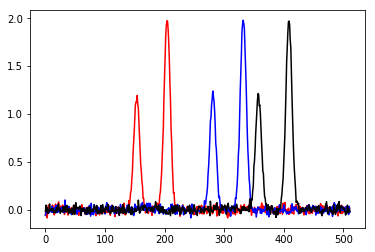

In [6]:
colors = ['r','b','k']
for i in range(nprof):
    plt.plot(data[i],color=colors[i])
plt.show()

# Phase shift and align profiles
Use brent's method to calculate tau, but for now just eyeball it since we know time delay

In [5]:
def phase_shift(data, basis=0, N=512, P=100):
    data2 = data.copy()
    
    for i in range(len(data)):
        if i != basis:
            #find tau, convert into nbins using taylor's paper, but
            #for now, makeshift using max value of profile
            
            #find delay
            ref = data[basis].tolist()
            m = ref.index(max(ref))
            comp = data[i].tolist()
            n = comp.index(max(comp))
            delay = n-m
            #find k, omega
            k = np.arange(N)
            omega = 2*np.pi*k / N
            #phase shift
            phase = np.exp(1j*omega*delay)
            yf = fft(data[i])
            iyf = ifft(yf * phase)
            data2[i] = iyf
    return data2

In [6]:
data2 = phase_shift(data)

/Users/MYK/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


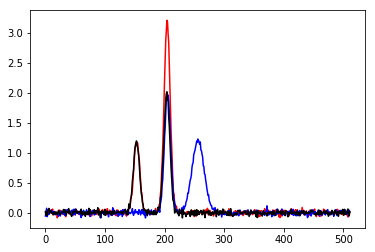

In [7]:
for i in range(nprof):
    plt.plot(data2[i], color = colors[i])
plt.show()

# Define ratios of successive profiles

In [8]:
ratio = []

for i in range(nprof-1):
    #+1 to avoid division by zero
    ratio.append( (data2[i+1]+1) / (data2[i]+1))
                 
ratio = np.array(ratio)
ratio -= 1

nratio = len(ratio)

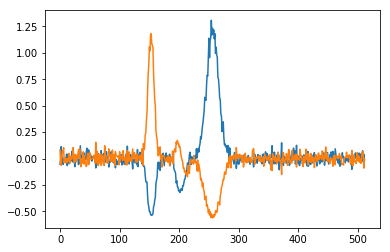

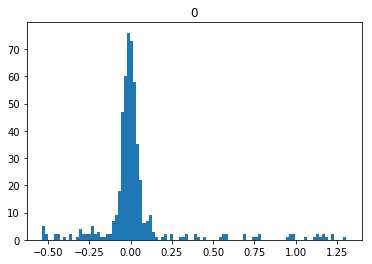

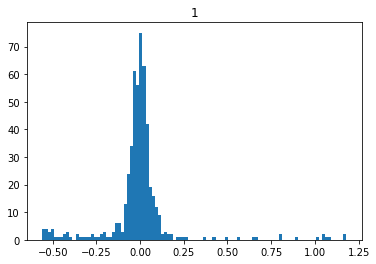

In [9]:
for i in range(nratio):
    plt.plot(ratio[i])
plt.show()

for i in range(nratio):
    plt.hist(ratio[i],bins=100)
    plt.title(i)
    plt.show()

# Find noise statistics for off pulse region in the profile ratios
This is assuming that between all the ratios, the noise statistics are assumed to have the same
true value. Should I be using each mu, sd for each ratio or taking average of all profiles?
Because then the chi square test is (as of now) for each ratio.

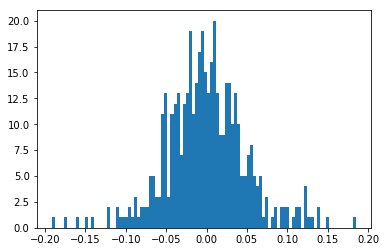

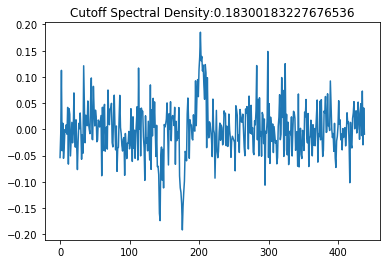

length of noise: 439
Delta: 0.013071559448340256
Iterations: 86


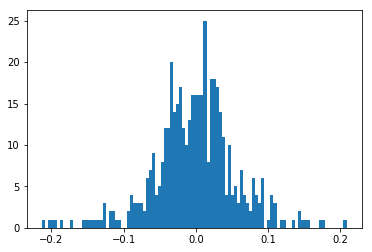

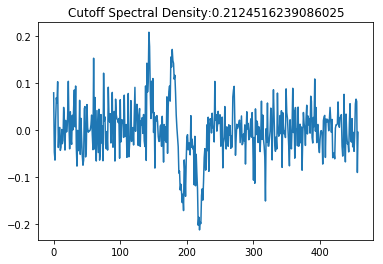

length of noise: 458
Delta: 0.011802867994922379
Iterations: 82
-0.000819358333349 0.0540627981441


In [10]:
mu = []
sd = []

for i in range(nratio):
    m,s = u.noise_stats_out(ratio[i], N=100,err = 2)
    mu.append(m)
    sd.append(s)
    
noise_mu = sum(mu)/nprof
noise_sd = u.average_sd(sd)
print(noise_mu,noise_sd)

# Chi-Square test
Not working even against just random noise?

In [11]:
u.chi_squared(ratio,noise_mu,noise_sd)

Between 0th and 1th profile, P( >chi squared): 0.0%
Between 1th and 2th profile, P( >chi squared): 0.0%


array([ 10817.56697708,   7087.41208299])

In [12]:
noise = np.random.randn(5,510)
chis = u.chi_squared(noise, 0, 1)

Between 0th and 1th profile, P( >chi squared): 0.0%
Between 1th and 2th profile, P( >chi squared): 0.0%
Between 2th and 3th profile, P( >chi squared): 0.0%
Between 3th and 4th profile, P( >chi squared): 0.0%
Between 4th and 5th profile, P( >chi squared): 0.0%


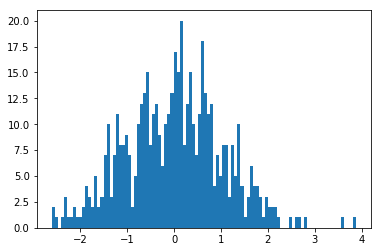

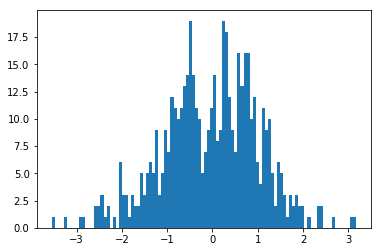

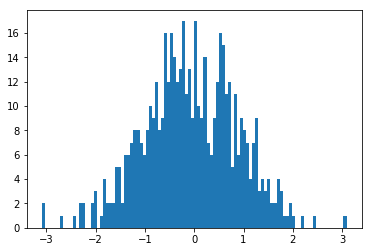

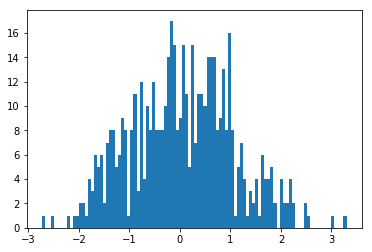

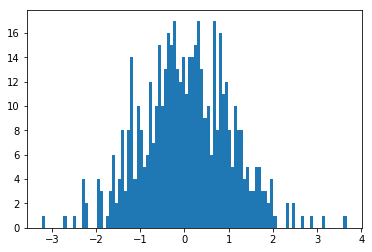

In [13]:
for i in range(len(noise)):
    plt.hist(noise[i],bins=100)
    plt.show()

In [14]:
#with open('ratios.txt','w+') as f:
#    csvWriter = csv.writer(f,delimiter=',')
#    csvWriter.writerows(ratio)

In [15]:
#write out so read as csv in R, perform change point detection cpts package
np.savetxt('ratios.txt',ratio)